# Waterbodies Animations

* **Products used:** [DE Africa Waterbodies](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html); [DE Africa WOfS](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html); [GeoMADs](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html); [CHIRPS](https://docs.digitalearthafrica.org/en/latest/data_specs/CHIRPS_specs.html)

## Background
The Digital Earth Africa Continental Waterbodies Monitoring Service identifies more than 700,000 water bodies from over three decades of satellite observations. This service maps persistent and seasonal water bodies and the change in their water surface area over time. Mapped water bodies may include, but are not limited to, lakes, ponds, man-made reservoirs, wetlands, and segments of some river systems. For more information on the waterbodies monitoring service, refer to the [Datasets notebook](../Datasets/Waterbodies.ipynb).

Often, it makes sense to visualise changes in waterbodies through time using animations. Animations are a form of exploratory analysis that can help show whether there is an overall trend in water extent or ilustrate repeating seasonal patterns. This notebook demonstrates how to generate animations for the time series component of waterbodies alongside summary data from Water Observations from Space, rainfall data, and true-colour imagery.

Firstly, an animation showing annual changes in water extent is produced. Then, an animation for a shorter period is produced to show seasonal changes in water extent.

**Disclaimer: DE Africa Waterbodies Surface Area Change measures the wet surface area of waterbodies as estimated from satellites. This product does not measure depth, volume, purpose of the waterbody, nor the source of the water.**

## Description
This notebook demonstrates the generation of two animations for inspecting changes in water extent, drawing on the [DE Africa Waterbodies service](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html). 

Steps taken are:

1. Loading and preparing annual time series, WOfS, and true-colour data.
2. Creating an animation for annual changes in water extent.
3. Loading and preparing monthly time series, rolling GeoMAD, and rainfall data.
4. Creating an animation that shows monthly and seasonal changes in water extent for a selected waterbody.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the “Load packages” cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import matplotlib.pyplot as plt
import datacube
import matplotlib.dates as mdates
import numpy as np
import matplotlib.animation as animation

from deafrica_tools.plotting import display_map
from IPython.display import HTML
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.waterbodies import (
    get_geohashes,
    get_waterbodies,
    get_waterbody,
    get_time_series,
    display_time_series,
)

In [2]:
dc = datacube.Datacube(app="Waterbody-anim")

## Analysis parameters

This section defines the analysis parameters, including:

* `lat`, `lon`, `buffer`: center lat/lon and analysis window size for the area of interest (in degrees)

The default area is Lake Baringo in Kenya which has experienced [an increase in extent over recent years](https://www.theguardian.com/world/2022/mar/17/kenya-quiet-slide-underwater-great-rift-valley-lakes-east-africa-flooding) and has [previously been studied with Digital Earth Africa](https://www.digitalearthafrica.org/media-center/blog/rising-lakes-rift-valley-kenya). 

In [3]:
# Set the central latitude and longitude
lat = 0.62
lon = 36.08

# Set the buffer to load around the central coordinates
buffer = 0.3

# Compute the bounding box coordinates
xlim = (lon - buffer, lon + buffer)
ylim = (lat + buffer, lat - buffer)

# Preview area on a map
display_map(xlim, ylim)

## Getting data

The `deafrica_waterbodies` module allows you to query water bodies by location or geohash. For more background, see the [waterbodies documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html) and the [waterbodies Datasets notebook](../Datasets/Waterbodies.ipynb).

### List waterbody polygons in an area
We can get a list of waterbody polygons inside a bounding box of coordinates using `get_waterbodies`.

In [4]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")

The returned geodataframe includes all the water bodies which are located within the bounding box. This dataset contains metadata for each water body in the dataset, including the ID, UID, WB_UID, area, perimeter and time series. See the [Waterbodies Historical Extent documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html#Waterbodies-Historical-Extent) for descriptions of each attribute.

### Explore and select the polygon

Once the water body polygons are in memory, you can plot them directly, or explore them in an interactive window.

In [5]:
# Explore the waterbody polygons located within the bounding box
polygons.explore()

#### Select geohash
Exploring the polygons above, we can see that our waterbody of interest, Lake Baringo, is represented by a single large polygon. There are numerous smaller polygons in the vicinity or immediately surrounding the lake. The geohash for the primary polygon (shown as `uid` when hovering the mouse) is `sb1ekyxw88`.

### Getting time series data

In [6]:
selected_waterbody_geohash = "sb1ekyxw88"

selected_waterbody = get_waterbody(selected_waterbody_geohash)

#### Get the wet surface area time series for the selected waterbody

For any given geohash or a polygon, we can also use the `get_time_series()` function to get various measures of the water body surface over time. See the [Waterbodies Historical Extent documentation](https://docs.digitalearthafrica.org/en/latest/data_specs/Waterbodies_specs.html#Waterbodies-Surface-Area-Change) for descriptions of the different surface measures.

The function also calculates a rolling median of the water body surface wet percentage.
This is used to visualise the overall trend in the surface wet percentage.
The rolling median uses the last three observations to determine the median at a given date.

In [7]:
# Get time series for the selected water body
selected_waterbody_timeseries = get_time_series(waterbody=selected_waterbody)

selected_waterbody_timeseries.head()

area_wet_m2  percent_wet  area_dry_m2  percent_dry  \
date                                                             
1984-05-30  142439400.0        62.88   79190100.0        34.96   
1984-06-15  147272400.0        65.01   79223400.0        34.97   
1984-07-01  147078900.0        64.92   79350300.0        35.03   
1984-07-17  147500100.0        65.11   78994800.0        34.87   
1984-12-08  132145200.0        58.33   83509200.0        36.86   

            area_invalid_m2  percent_invalid  area_observed_m2  \
date                                                             
1984-05-30        4910400.0             2.17       226539900.0   
1984-06-15          44100.0             0.02       226539900.0   
1984-07-01         110700.0             0.05       226539900.0   
1984-07-17          45000.0             0.02       226539900.0   
1984-12-08       10885500.0             4.81       226539900.0   

            percent_observed  percent_wet_rolling_median  
date                                                      
1984-05-30             100.0                         NaN  
1984-06-15             100.0                         NaN  
1984-07-01             100.0                       64.92  
1984-07-17             100.0                       65.01  
1984-12-08             100.0                       64.92

#### Display the wet surface area time series for the selected waterbody

After loading the water body time series, we can use the `display_time_series()` function to create an interactive visualisation of the time series.

The visualisation shows the invalid percentage and the wet percentage. 

Limited data availability prior to 2009 is evident, due to the combination of sensor presence (Landsat-8 was launced in 2013 and Landsat-9 in 2021) and data quality.

The increase in water extent from 2010 to present is clearly observable in the time series.

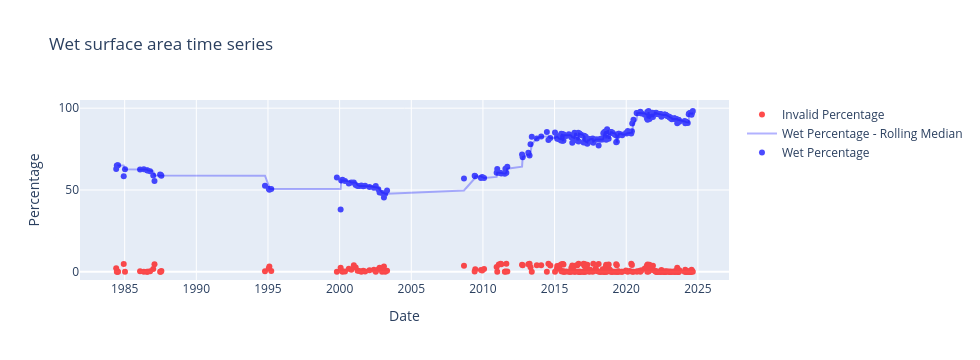

In [8]:
display_time_series(selected_waterbody_timeseries)

## Load true colour GeoMADs

The cloud-free geomedian annual composite images are a great source of true-colour data to present alongside annual changes in water extent. The cell below loads true colour bands (red, green, and blue) from three annual GeoMAD products: Landsat-5 & Landsat-7 combined, Landsat-8, and Landsat-8 & Landsat-9 combined. This produces a neat time series of annual images for our period of interest, beginning in 2009 due to data availability.

In [9]:
lat_range = (selected_waterbody.total_bounds[1], selected_waterbody.total_bounds[3])
lon_range = (selected_waterbody.total_bounds[0], selected_waterbody.total_bounds[2])

ds = dc.load(
    product=["gm_ls5_ls7_annual", "gm_ls8_annual", "gm_ls8_ls9_annual"],
    measurements=["red", "green", "blue"],
    x=lon_range,
    y=lat_range,
    resolution=(-30, 30),
    dask_chunks={"time": 1, "x": 3000, "y": 3000},
    time=("2009-01-01", "2022-12-31"),
).compute()

## Load Water Observations from Space (WOfS) annual summary

Our first animation will overlay WOfS onto the true colour imagery. As we are producing an annual animation, the WOfS annual summary is a logical product to use.

In [10]:
query = {
    "x": lon_range,
    "y": lat_range,
    "time": ("2009-01-01", "2022-12-31"),
    "resolution": (-30, 30),
}

wofs = dc.load(product="wofs_ls_summary_annual", output_crs="epsg:6933", **query)

### Mask WOfS to waterbody

The WOfS data needs to be masked to the maximum extent of the waterbody to produce a neat overlay. The waterbody polygon is first rasterised then applied as a mask. The resulting WOfS layer is then plotted to check that masking has worked as expected.

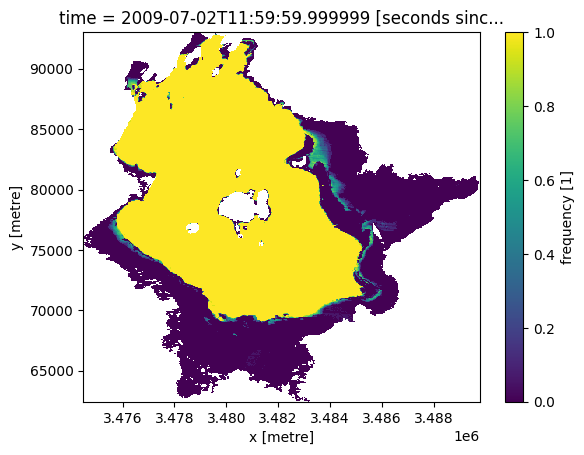

In [11]:
mask = xr_rasterize(selected_waterbody, wofs)
clipped_wofs = wofs.where(mask)

clipped_wofs.frequency.isel(time=0).plot()

### Clip and resample waterbody time series

The timeseries needs to be the same length as the raster datasets to produce an intuitive animation. This means we need to resample the time series to annual time steps and limit it to between 2009 and 2022.

In [12]:
tsw = (
    selected_waterbody_timeseries.percent_wet.loc["2009-01-01":"2022-12-31"]
    .resample("1Y")
    .mean()
    .interpolate()
)

tsw

date
2009-12-31    58.107500
2010-12-31    58.945000
2011-12-31    61.466250
2012-12-31    70.880000
2013-12-31    77.166000
2014-12-31    82.610000
2015-12-31    82.553125
2016-12-31    82.785882
2017-12-31    80.502353
2018-12-31    83.196000
2019-12-31    83.286923
2020-12-31    90.783636
2021-12-31    95.685000
2022-12-31    96.086667
Freq: A-DEC, Name: percent_wet, dtype: float64

Printing the length of each time series to be included in the animation ensures they have equal lengths.

In [13]:
print(len(ds.time))
print(len(clipped_wofs.time))
print(len(tsw))

14
14
14


## Generate annual animation

The code in the cell below produces an animation at annual timesteps. The first sections of the cell set up the plotting structure, then the data for each axis is set. An `update` function then determines the rules for updating each time series through annual time steps.

The output can be saved as a `.gif` file by uncommenting (removing the `#`) the `ani.save()` line.

The animation shows a marked increase in water extent between 2010 and 2015, then a steadying until 2020 before a steep increase. Both steep increases in water extent are associated with greening of the background landscape.

In [14]:
# create a figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)

ax1.set_title("Waterbodies Timeseries")
ax1.set_xlabel("Date")
ax1.set_ylabel("Surface water extent (%)")
years = mdates.YearLocator(2)
ax1.xaxis.set_major_locator(years)
ax1.tick_params(axis="x", labelrotation=45)

bands = ["red", "green", "blue"]

cax = (
    ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze().clip(0, 3000)
    / np.max(
        ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze().clip(0, 3000)
    )
).plot.imshow(rgb="variable", animated=True, robust=True, ax=ax2)
dax = clipped_wofs.frequency[0, :, :].plot(cmap="Blues", ax=ax2)
selected_waterbody.plot(ax=ax2, edgecolor="black", color="none")


def update(num, x, y, line):
    dax.set_array(clipped_wofs.frequency[num, :, :])
    cax.set_array(
        (ds[bands].isel(time=num).to_array().transpose("y", "x", "variable"))
        .squeeze()
        .clip(0, 3000)
        / np.max(ds[bands].isel(time=num).to_array().transpose("y", "x", "variable"))
        .squeeze()
        .clip(0, 3000)
    )
    ax2.set_title("Time = " + str(clipped_wofs.frequency.coords["time"].values[(num)])[:12])
    line.set_data(x[:num], y[:num])
    return (line,)


x = tsw.index
y = tsw.values

(line,) = ax1.plot(x, y)

plt.tight_layout()

ani = animation.FuncAnimation(
    fig, update, len(ds.time), fargs=[x, y, line], interval=800, blit=True
)
# ani.save('LakeBaringo_Kenya_ts.gif')

plt.close()
HTML(ani.to_html5_video())

# Seasonal surface water extent and rainfall

Next, an animation showing monthly progression of water extent over a shorter time period will be produced. 

The default waterbody is [Mtera Reservoir in Tanzania](https://en.wikipedia.org/wiki/Mtera_Dam). This is a hydroelectric dam so water extent is somewhat under the influence of human decision-making.

In [15]:
# Set the central latitude and longitude
lat = -7.05
lon = 35.83

# Set the buffer to load around the central coordinates
buffer = 0.3

# Compute the bounding box coordinates
xlim = (lon - buffer, lon + buffer)
ylim = (lat + buffer, lat - buffer)

# Preview area on a map
display_map(xlim, ylim)

## Select waterbody

We use the same procedure as above to load available polygons within a specified area and select the waterbody of interest.

In [16]:
# Create a bounding box from study area coordinates
bbox = (xlim[0], ylim[1], xlim[1], ylim[0])

# Select all water bodies located within the bounding box
polygons = get_waterbodies(bbox, crs="EPSG:4326")

# Explore the waterbody polygons located within the bounding box
polygons.explore()

### Inspect time series

The time series for the Mtera Reservoir shows some seasonal variation in water extent, often with with very large filling events followed by progressive contraction of water extent.

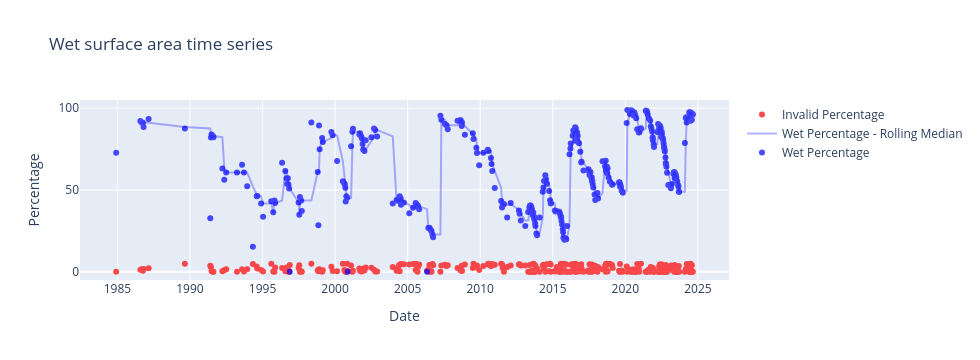

In [17]:
selected_waterbody_geohash = "ky9rzpq3c0"
selected_waterbody = get_waterbody(selected_waterbody_geohash)

# Get time series for the selected water body
selected_waterbody_timeseries = get_time_series(waterbody=selected_waterbody)

display_time_series(selected_waterbody_timeseries)

### Prepare time series for plotting

The water extent time series needs to be prepared for inclusion in the animation, as below.

In [18]:
tsw = (
    selected_waterbody_timeseries.percent_wet.loc["2019-01-15":"2023-12-16"]
    .resample("1M")
    .mean()
    .interpolate()
)

### Load rolling GeoMAD

For this animation, we are interested in seasonal variation in water extent and land surface condition, so we are using the 3-monthly rolling geomedian at monthly timesteps. The rolling GeoMAD for the relevant period and extent is loaded below, with the red, green, and blue bands loaded for true colour visualisation.

In [19]:
lat_range = (selected_waterbody.total_bounds[1], selected_waterbody.total_bounds[3])
lon_range = (selected_waterbody.total_bounds[0], selected_waterbody.total_bounds[2])

ds = dc.load(
    product=["gm_s2_rolling"],
    measurements=["red", "green", "blue"],
    x=lon_range,
    y=lat_range,
    resolution=(-30, 30),
    dask_chunks={"time": 1, "x": 3000, "y": 3000},
    time=("2019-02-01", "2023-11-30"),
).compute()

### Load monthly rainfall

Plotting monthly rainfall alongside water extent assists in understanding seasonal patterns in waterbody state. The cell below loads monthly rainfall from CHIRPS and prepares it as a time series data frame by dropping the spatial dimensions.

In [20]:
ds_rf = dc.load(
    product="rainfall_chirps_monthly",
    measurements=["rainfall"],
    x=lon_range,
    y=lat_range,
    time=("2019-01-01", "2023-12-31"),
)

ds_rf_month = ds_rf.mean(["longitude", "latitude"]).to_dataframe().drop(["spatial_ref"], axis=1)

### Develop time series and rainfall chart

For this animation, rainfall and surface water extent will be presented alongside a true colour representation of the waterbody. 

To present rainfall and surface extent, we follow conventions of the [hydrograph](https://www.futurelearn.com/info/courses/urban-stormwater-management-in-a-changing-climate/0/steps/349504) which is traditionally used to display rainfall and runoff. A unique convention is that rainfall is presented on a reversed secondary y-axis, that is, falling from the top.

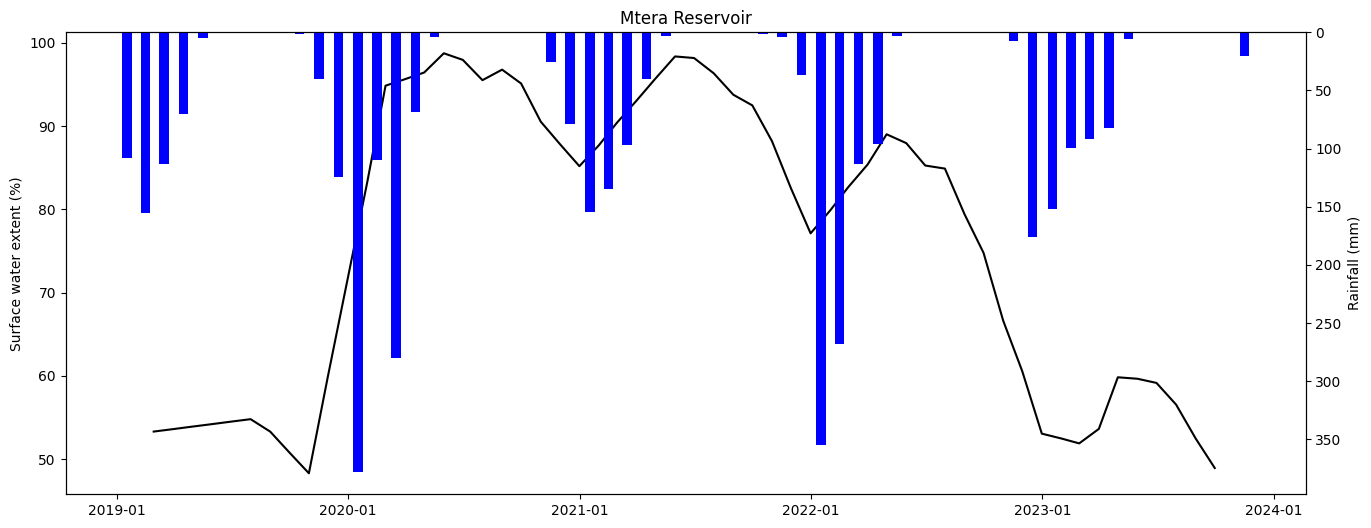

In [21]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax2 = ax1.twinx()
ax2.invert_yaxis()
ax2.bar(ds_rf_month.index, ds_rf_month.rainfall, width=15, align="center", color="b")
ax2.set_ylabel("Rainfall (mm)")

ax1.plot(tsw, color="k")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.set_ylabel("Surface water extent (%)")

plt.title("Mtera Reservoir");

## Generate seasonal animation

Finally, we run the animation. The block of code below prepares the figure layout then defines starting data to be presented. The update function displays new data for each component of the animation at a common interval.

The animation output can be saved and then downloaded by uncommenting (removing the `#`) the command `ani.save('MteraReservoir.gif')`.

In [22]:
# create a figure and axes
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(122)
ax2 = plt.subplot(121)

ax1.set_title("Monthly rainfall and water extent")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Precipitation (mm)")

bands = ["red", "green", "blue"]


cax = (
    ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze()
    / np.max(ds[bands].isel(time=0).to_array().transpose("y", "x", "variable").squeeze())
).plot.imshow(rgb="variable", animated=True, robust=True)

ax3 = ax1.twinx()
bars = ax3.bar(ds_rf_month.index, ds_rf_month.rainfall * [0], width=15, align="center", color="b")
ax3.set_ylabel("Rainfall (mm)")
ax3.set_ylim(0, np.max(ds_rf_month.rainfall) + 20)
ax3.invert_yaxis()

x = tsw.index
y = tsw.values

(line,) = ax1.plot(x, y, color="k")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.tick_params(axis="x", labelrotation=45)
ax1.set_ylabel("Surface water extent (%)")


def update(num, x, y, bars, line):
    cax.set_array(
        (
            ds[bands]
            .isel(time=num)
            .to_array()
            .transpose("y", "x", "variable")
            .squeeze()
            .clip(0, 2500)
            / np.max(
                ds[bands]
                .isel(time=num)
                .to_array()
                .transpose("y", "x", "variable")
                .squeeze()
                .clip(0, 2500)
            )
        )
    )
    ax2.set_title("Time = " + str(ds[bands].coords["time"].values[(num)])[:12])
    bars[num].set_height(ds_rf_month.rainfall.iloc[num])
    line.set_data(x[:num], y[:num])
    return (line,)


plt.tight_layout()

ani = animation.FuncAnimation(
    fig, update, len(x) - 1, fargs=[x, y, bars, line], interval=300, blit=True
)
# ani.save('MteraReservoir.gif')

plt.close()
HTML(ani.to_html5_video())

## Conclusion

This notebook has demonstrated two animations for visualising waterbodies over different periods. The techniques and code shown here can be adapted to user defined purposes. These visualisations can be useful for exploratory analysis of trends in water extent over several years, or seasonal patterns in water extent and relationships with rainfall patterns. More formal trend and pattern analysis would need to be undertaken to better understand these phenomena.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
import datacube

print(datacube.__version__)

1.8.19


**Last Tested:**

In [24]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2024-09-03'